In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import logging
import os
import warnings

import torch
from torch.utils.data import Dataset, DataLoader

os.chdir("/home/qian.hu/neuron_process_waveform/npf_GWwaveform")

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
logging.disable(logging.ERROR)

N_THREADS = 10
IS_FORCE_CPU = False  # Nota Bene : notebooks don't deallocate GPU memory

if IS_FORCE_CPU:
    os.environ["CUDA_VISIBLE_DEVICES"] = ""

torch.set_num_threads(N_THREADS)
import h5py
#10:2:1=train:test:valid

import scipy
import matplotlib.pyplot as plt
import numpy as np
from utils import visualize_1d
from utils.ntbks_helpers import get_all_gp_datasets
from npf.utils.helpers import rescale_range

from gw.utils import gwutils

import bilby


In [2]:
torch.cuda.is_available()

True

In [2]:
root_dir = '/home/qian.hu/neuron_process_waveform/npf_GWwaveform/data/'
h5filename = root_dir + 'gw_fd_8D_q7a5_2N2000_Pv2v4P_downsampled.h5'

Ngw = gwutils.get_gwfdh5_nsample(h5filename)

Ntrain = int(Ngw*0.7)
Ntest = int(Ngw*0.15)
Nvalid = Ngw - Ntrain - Ntest

random_index = np.random.permutation(Ngw)
train_index = random_index[:Ntrain]
test_index = random_index[Ntrain:Ntrain+Ntest]
valid_index = random_index[-Nvalid:]

gw_dataset = gwutils.GWDatasetFDMultimodel(h5file=h5filename, indcies=train_index)
gw_test_dataset = gwutils.GWDatasetFDMultimodel(h5file=h5filename, indcies=test_index)
gw_valid_dataset = gwutils.GWDatasetFDMultimodel(h5file=h5filename, indcies=valid_index)


In [3]:
gw_dataset.n_samples

700

In [3]:
train_label = 'IMRPv2EOBv4P_q7a5fd_2N2000'

gw_datasets = {}
gw_test_datasets = {}
gw_valid_datasets = {}

gw_datasets[train_label] = gw_dataset
gw_test_datasets[train_label] = gw_test_dataset
gw_valid_datasets[train_label] = gw_valid_dataset

In [4]:
from utils.ntbks_helpers import get_all_gp_datasets, get_img_datasets

from npf.utils.datasplit import (
    CntxtTrgtGetter,
    GetRandomIndcs,
    GridCntxtTrgtGetter,
    RandomMasker,
    get_all_indcs, ##
    no_masker,
)
from utils.data import cntxt_trgt_collate, get_test_upscale_factor

# CONTEXT TARGET SPLIT
get_cntxt_trgt_1d = cntxt_trgt_collate(
    CntxtTrgtGetter(
        contexts_getter=GetRandomIndcs(a=0.3, b=0.5), targets_getter=GetRandomIndcs(a=0.3, b=0.5), #GetRandomIndcs(a=0.8, b=0.9)
    )
)

In [5]:
from functools import partial

from npf import ConvCNP, GridConvCNP
from npf.architectures import CNN, MLP, ResConvBlock, SetConv, discard_ith_arg
from npf.utils.helpers import CircularPad2d, make_abs_conv, make_padded_conv
from utils.helpers import count_parameters

R_DIM = 128
KWARGS = dict(
    r_dim=R_DIM,
    Decoder=discard_ith_arg(  # disregards the target features to be translation equivariant
        partial(MLP, n_hidden_layers=4, hidden_size=R_DIM), i=0
    ),
)


CNN_KWARGS = dict(
    ConvBlock=ResConvBlock,
    is_chan_last=True,  # all computations are done with channel last in our code
    n_conv_layers=2,  # layers per block
)


# off the grid
model_1d = partial(
    ConvCNP,
    x_dim=1,
    y_dim=1,
    Interpolator=SetConv,
    CNN=partial(
        CNN,
        Conv=torch.nn.Conv1d,
        Normalization=torch.nn.BatchNorm1d,
        n_blocks=5,
        kernel_size=19,
        **CNN_KWARGS,
    ),
    density_induced=64,  # density of discretization
    **KWARGS,
)

n_params_1d = count_parameters(model_1d())
print(f"Number Parameters (1D): {n_params_1d:,d}")

Number Parameters (1D): 276,612


In [6]:
import skorch
from npf import CNPFLoss
from utils.ntbks_helpers import add_y_dim
from utils.train import train_models

KWARGS = dict(
    is_retrain=False,  # whether to load precomputed model or retrain
    is_continue_train=False,
    criterion=CNPFLoss,
    chckpnt_dirname="/home/qian.hu/neuron_process_waveform/npf_GWwaveform/gw/trained_models/",
    device="cuda",
    lr=5e-5,
    decay_lr=10,
    seed=123,
    batch_size=4,
)

# 1D
trainers_1d = train_models(
    gw_datasets,
    {"ConvCNP": model_1d},
    test_datasets=gw_test_datasets,
    iterator_train__collate_fn=get_cntxt_trgt_1d,
    iterator_valid__collate_fn=get_cntxt_trgt_1d,
    max_epochs=50,
    **KWARGS
)




--- Loading IMRPv2EOBv4P_q7a5fd_2N2000/ConvCNP/run_0 ---

IMRPv2EOBv4P_q7a5fd_2N2000/ConvCNP/run_0 | best epoch: 97 | train loss: -5648.1559 | valid loss: -5317.3969 | test log likelihood: 3739.7798


In [7]:
model_pv2v4p = trainers_1d[f'{train_label}/ConvCNP/run_0'].module_

testset = gw_test_datasets[f'{train_label}']

In [8]:
gw_test_dataset.waveform_models

array(['IMRPhenomPv2', 'SEOBNRv4P'], dtype='<U12')

In [9]:
#look_approx = 'IMRPhenomPv2'
look_index = 2
chirp_mass_look = gw_test_dataset.source_parameters['chirp_mass'][look_index]

x_test_imr, y_test_imr = gw_test_dataset.get_specific_model(look_index, 'IMRPhenomPv2')
x_test_eob, y_test_eob = gw_test_dataset.get_specific_model(look_index, 'SEOBNRv4P')

len_data = len(x_test_imr)
len_context = int(len_data*1)
context_index = np.sort( np.random.permutation(len_data)[:len_context] )
target_index = np.arange(len_data)

x_test_context_imr = x_test_imr[context_index]
y_test_context_imr = y_test_imr[context_index]

x_test_context_eob = x_test_eob[context_index]
y_test_context_eob = y_test_eob[context_index]

x_test_target_imr = x_test_imr[target_index]
x_yest_target_imr = y_test_imr[target_index]
x_test_target_eob = x_test_eob[target_index]
x_yest_target_eob = y_test_eob[target_index]




In [37]:
x_test_target_imr_unsc, y_test_target_imr_unsc = gw_test_dataset.get_specific_model(look_index, 'IMRPhenomPv2', rescalex=False)
x_test_target_imr_unsc = x_test_target_imr_unsc.squeeze().numpy()
y_test_target_imr_unsc = y_test_target_imr_unsc.squeeze().numpy()

x_test_target_eob_unsc, y_test_target_eob_unsc = gw_test_dataset.get_specific_model(look_index, 'SEOBNRv4P', rescalex=False)
x_test_target_eob_unsc = x_test_target_eob_unsc.squeeze().numpy()
y_test_target_eob_unsc = y_test_target_eob_unsc.squeeze().numpy()

In [38]:
nsample = 1
mean_imr, std_imr = gwutils.get_predictions(model_pv2v4p, x_test_context_imr.unsqueeze(0), y_test_context_imr.unsqueeze(0),
                                    x_test_target_imr.unsqueeze(0), nsample)
mean_eob, std_eob = gwutils.get_predictions(model_pv2v4p, x_test_context_eob.unsqueeze(0), y_test_context_eob.unsqueeze(0),
                                    x_test_target_eob.unsqueeze(0), nsample)

In [43]:
real_freq_test_imr, real_amp_test_imr = gwutils.unscale_scaled_fdwaveforms(x_test_target_imr_unsc, [y_test_target_imr_unsc], chirp_mass_look)
real_freq_test_imr, real_mean_test_imr = gwutils.unscale_scaled_fdwaveforms(x_test_target_imr_unsc, [mean_imr], chirp_mass_look)
real_freq_test_imr, real_std_test_imr = gwutils.unscale_scaled_fdwaveforms(x_test_target_imr_unsc, [std_imr], chirp_mass_look)


real_freq_test_eob, real_amp_test_eob = gwutils.unscale_scaled_fdwaveforms(x_test_target_eob_unsc, [y_test_target_eob_unsc], chirp_mass_look)
real_freq_test_eob, real_mean_test_eob = gwutils.unscale_scaled_fdwaveforms(x_test_target_eob_unsc, [mean_eob], chirp_mass_look)
real_freq_test_eob, real_std_test_eob = gwutils.unscale_scaled_fdwaveforms(x_test_target_eob_unsc, [std_eob], chirp_mass_look)

real_amp_test_imr = real_amp_test_imr[0]
real_mean_test_imr = real_mean_test_imr[0]
real_std_test_imr = real_std_test_imr[0]
real_amp_test_eob = real_amp_test_eob[0]
real_mean_test_eob = real_mean_test_eob[0]
real_std_test_eob = real_std_test_eob[0]


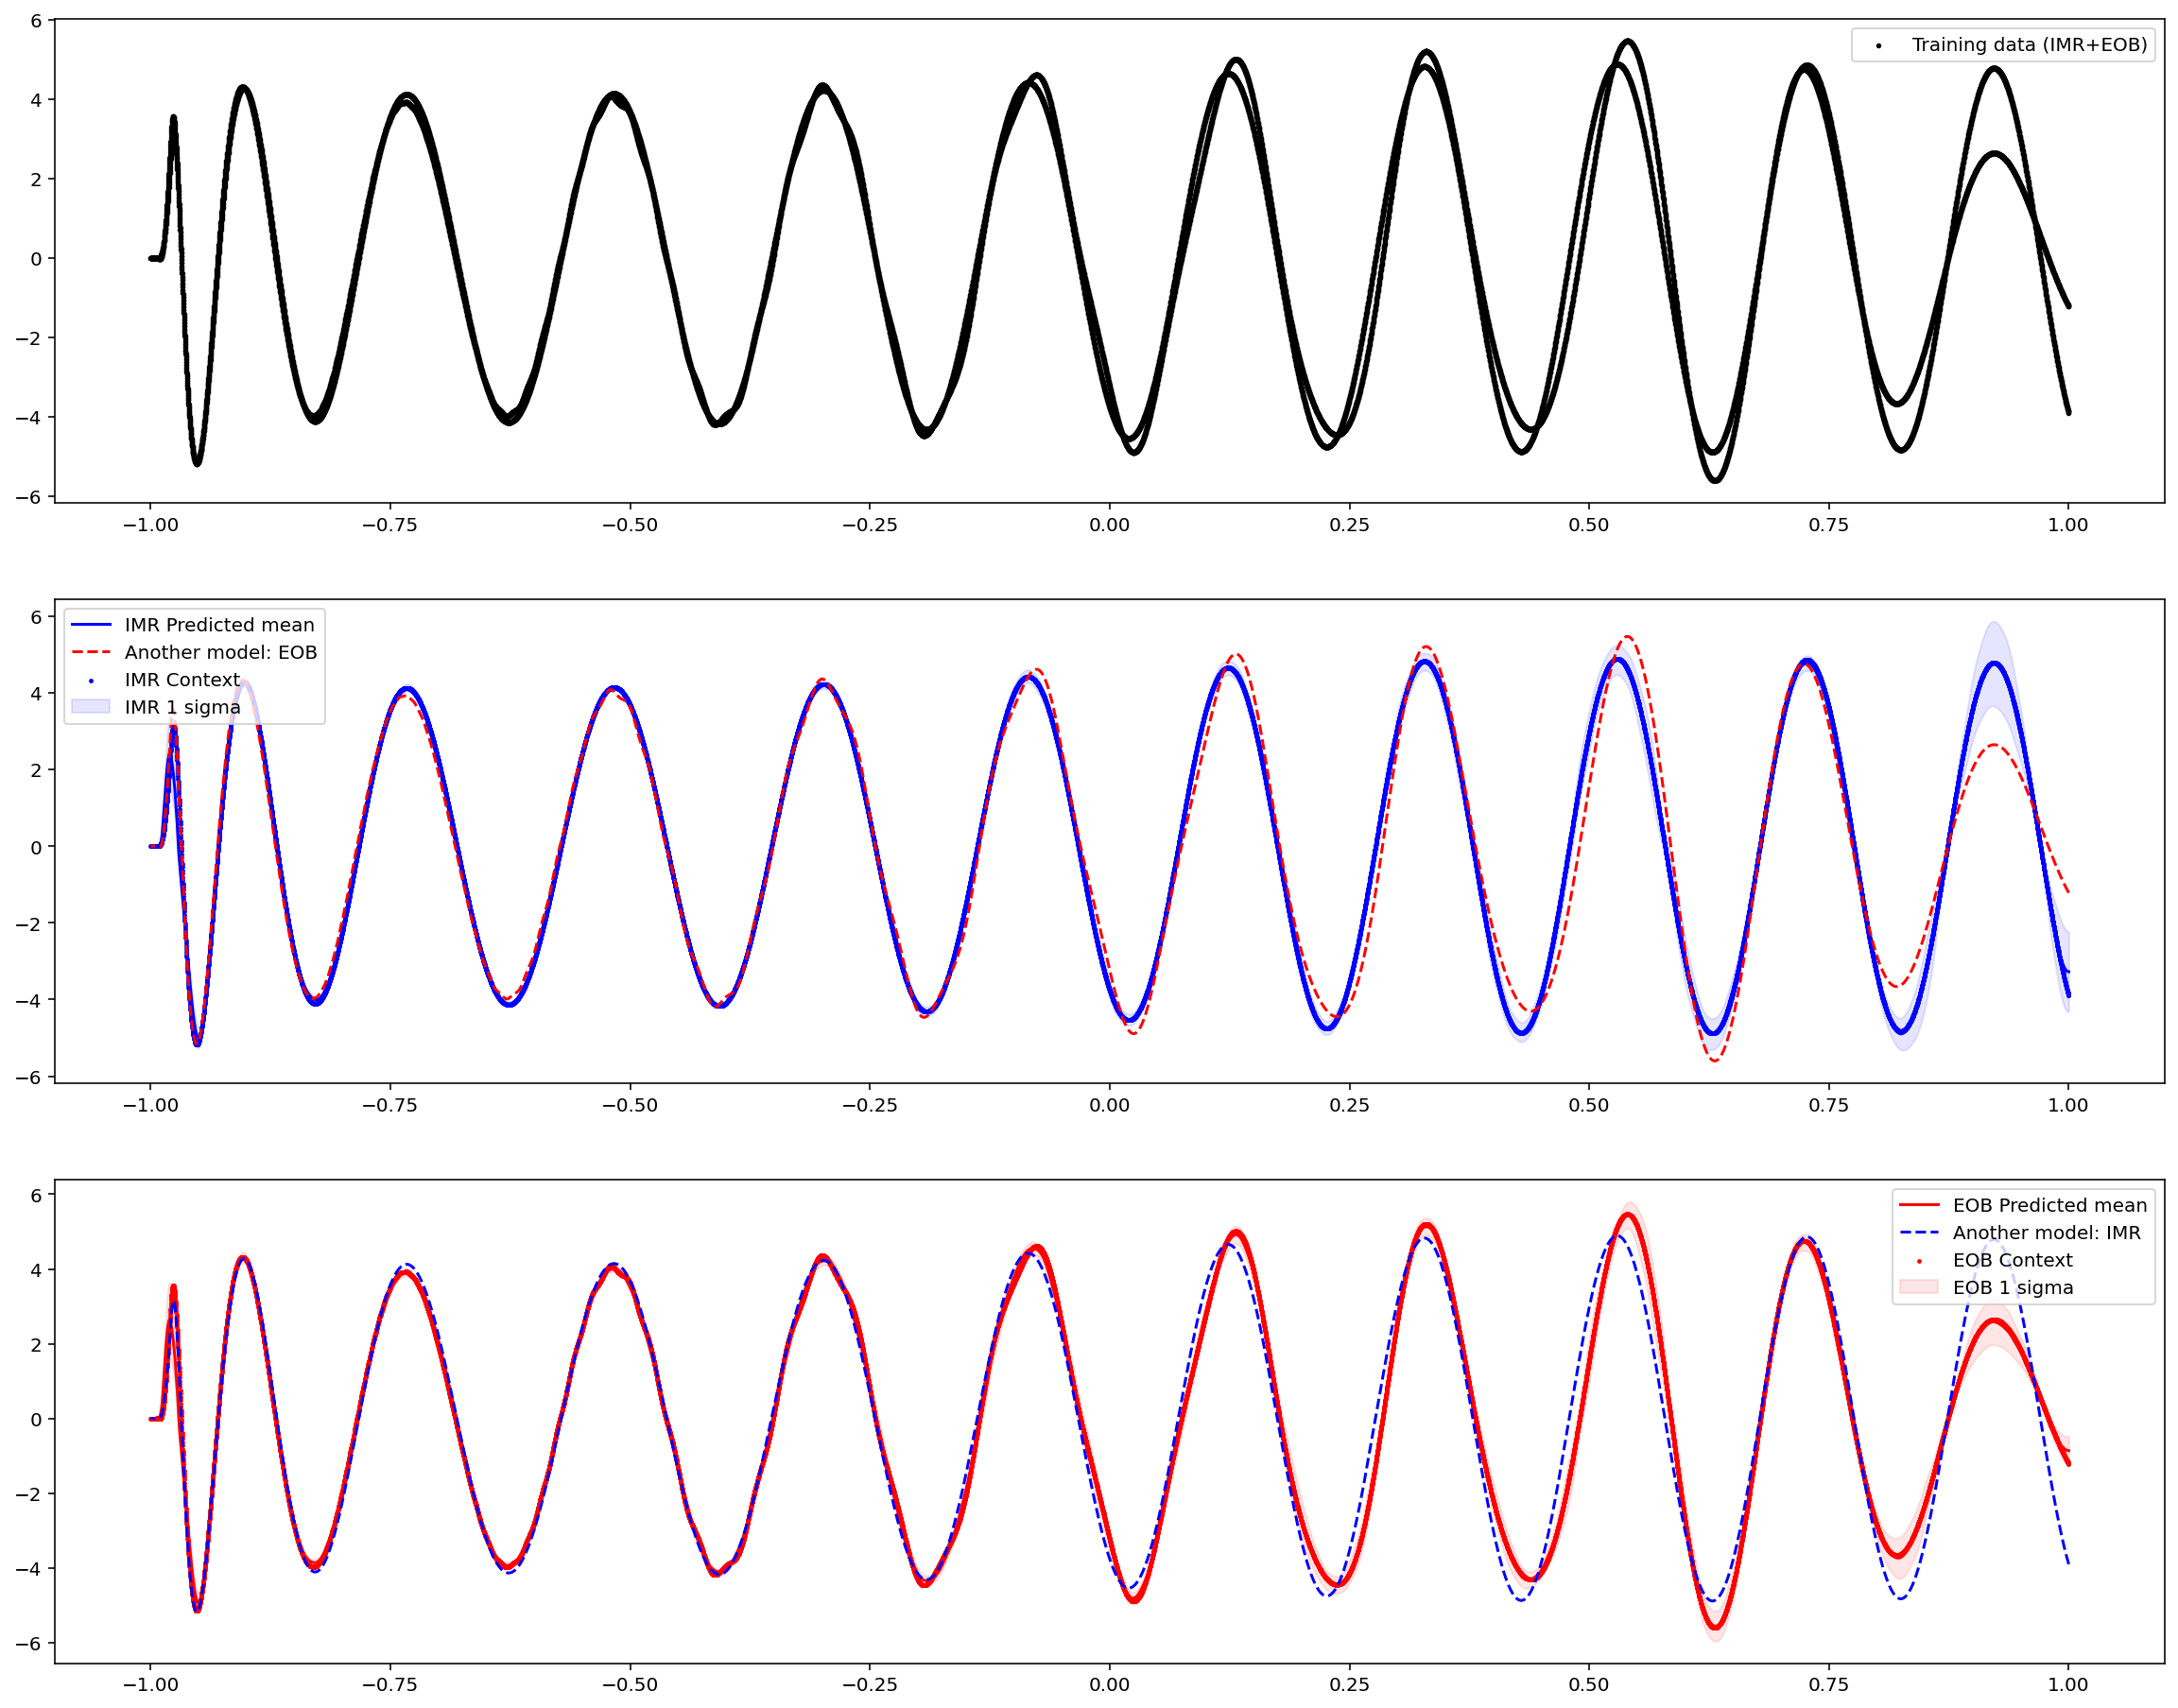

In [12]:
plt.figure(figsize=(20,16))
plt.subplot(3,1,1)
plt.scatter(gw_test_dataset[look_index][0], gw_test_dataset[look_index][1], label='Training data (IMR+EOB)', color='k',s=3)
plt.legend()

plt.subplot(3,1,2)
plt.scatter(x_test_context_imr, y_test_context_imr, label='IMR Context', color='b',s=2)
plt.plot(x_test_target_imr, mean_imr, label='IMR Predicted mean', color='b',linestyle='-')
plt.fill_between(x=x_test_target_imr.squeeze(), y1=mean_imr-std_imr, y2=mean_imr+std_imr, label='IMR 1 sigma', alpha=0.1, color='b')
plt.plot(x_test_eob, y_test_eob, label='Another model: EOB', color='r',linestyle='--')
plt.legend()
#plt.xlim(-0.,0.7)

plt.subplot(3,1,3)
plt.scatter(x_test_context_eob, y_test_context_eob, label='EOB Context', color='r',s=2)
plt.plot(x_test_target_eob, mean_eob, label='EOB Predicted mean', color='r',linestyle='-')
plt.fill_between(x=x_test_target_eob.squeeze(), y1=mean_eob-std_eob, y2=mean_eob+std_eob, label='EOB 1 sigma', alpha=0.1, color='r')
plt.plot(x_test_imr, y_test_imr, label='Another model: IMR', color='b',linestyle='--')
plt.legend()

#plt.savefig('/home/qian.hu/neuron_process_waveform/test/trained_models/gp_reprod.png')
plt.show()

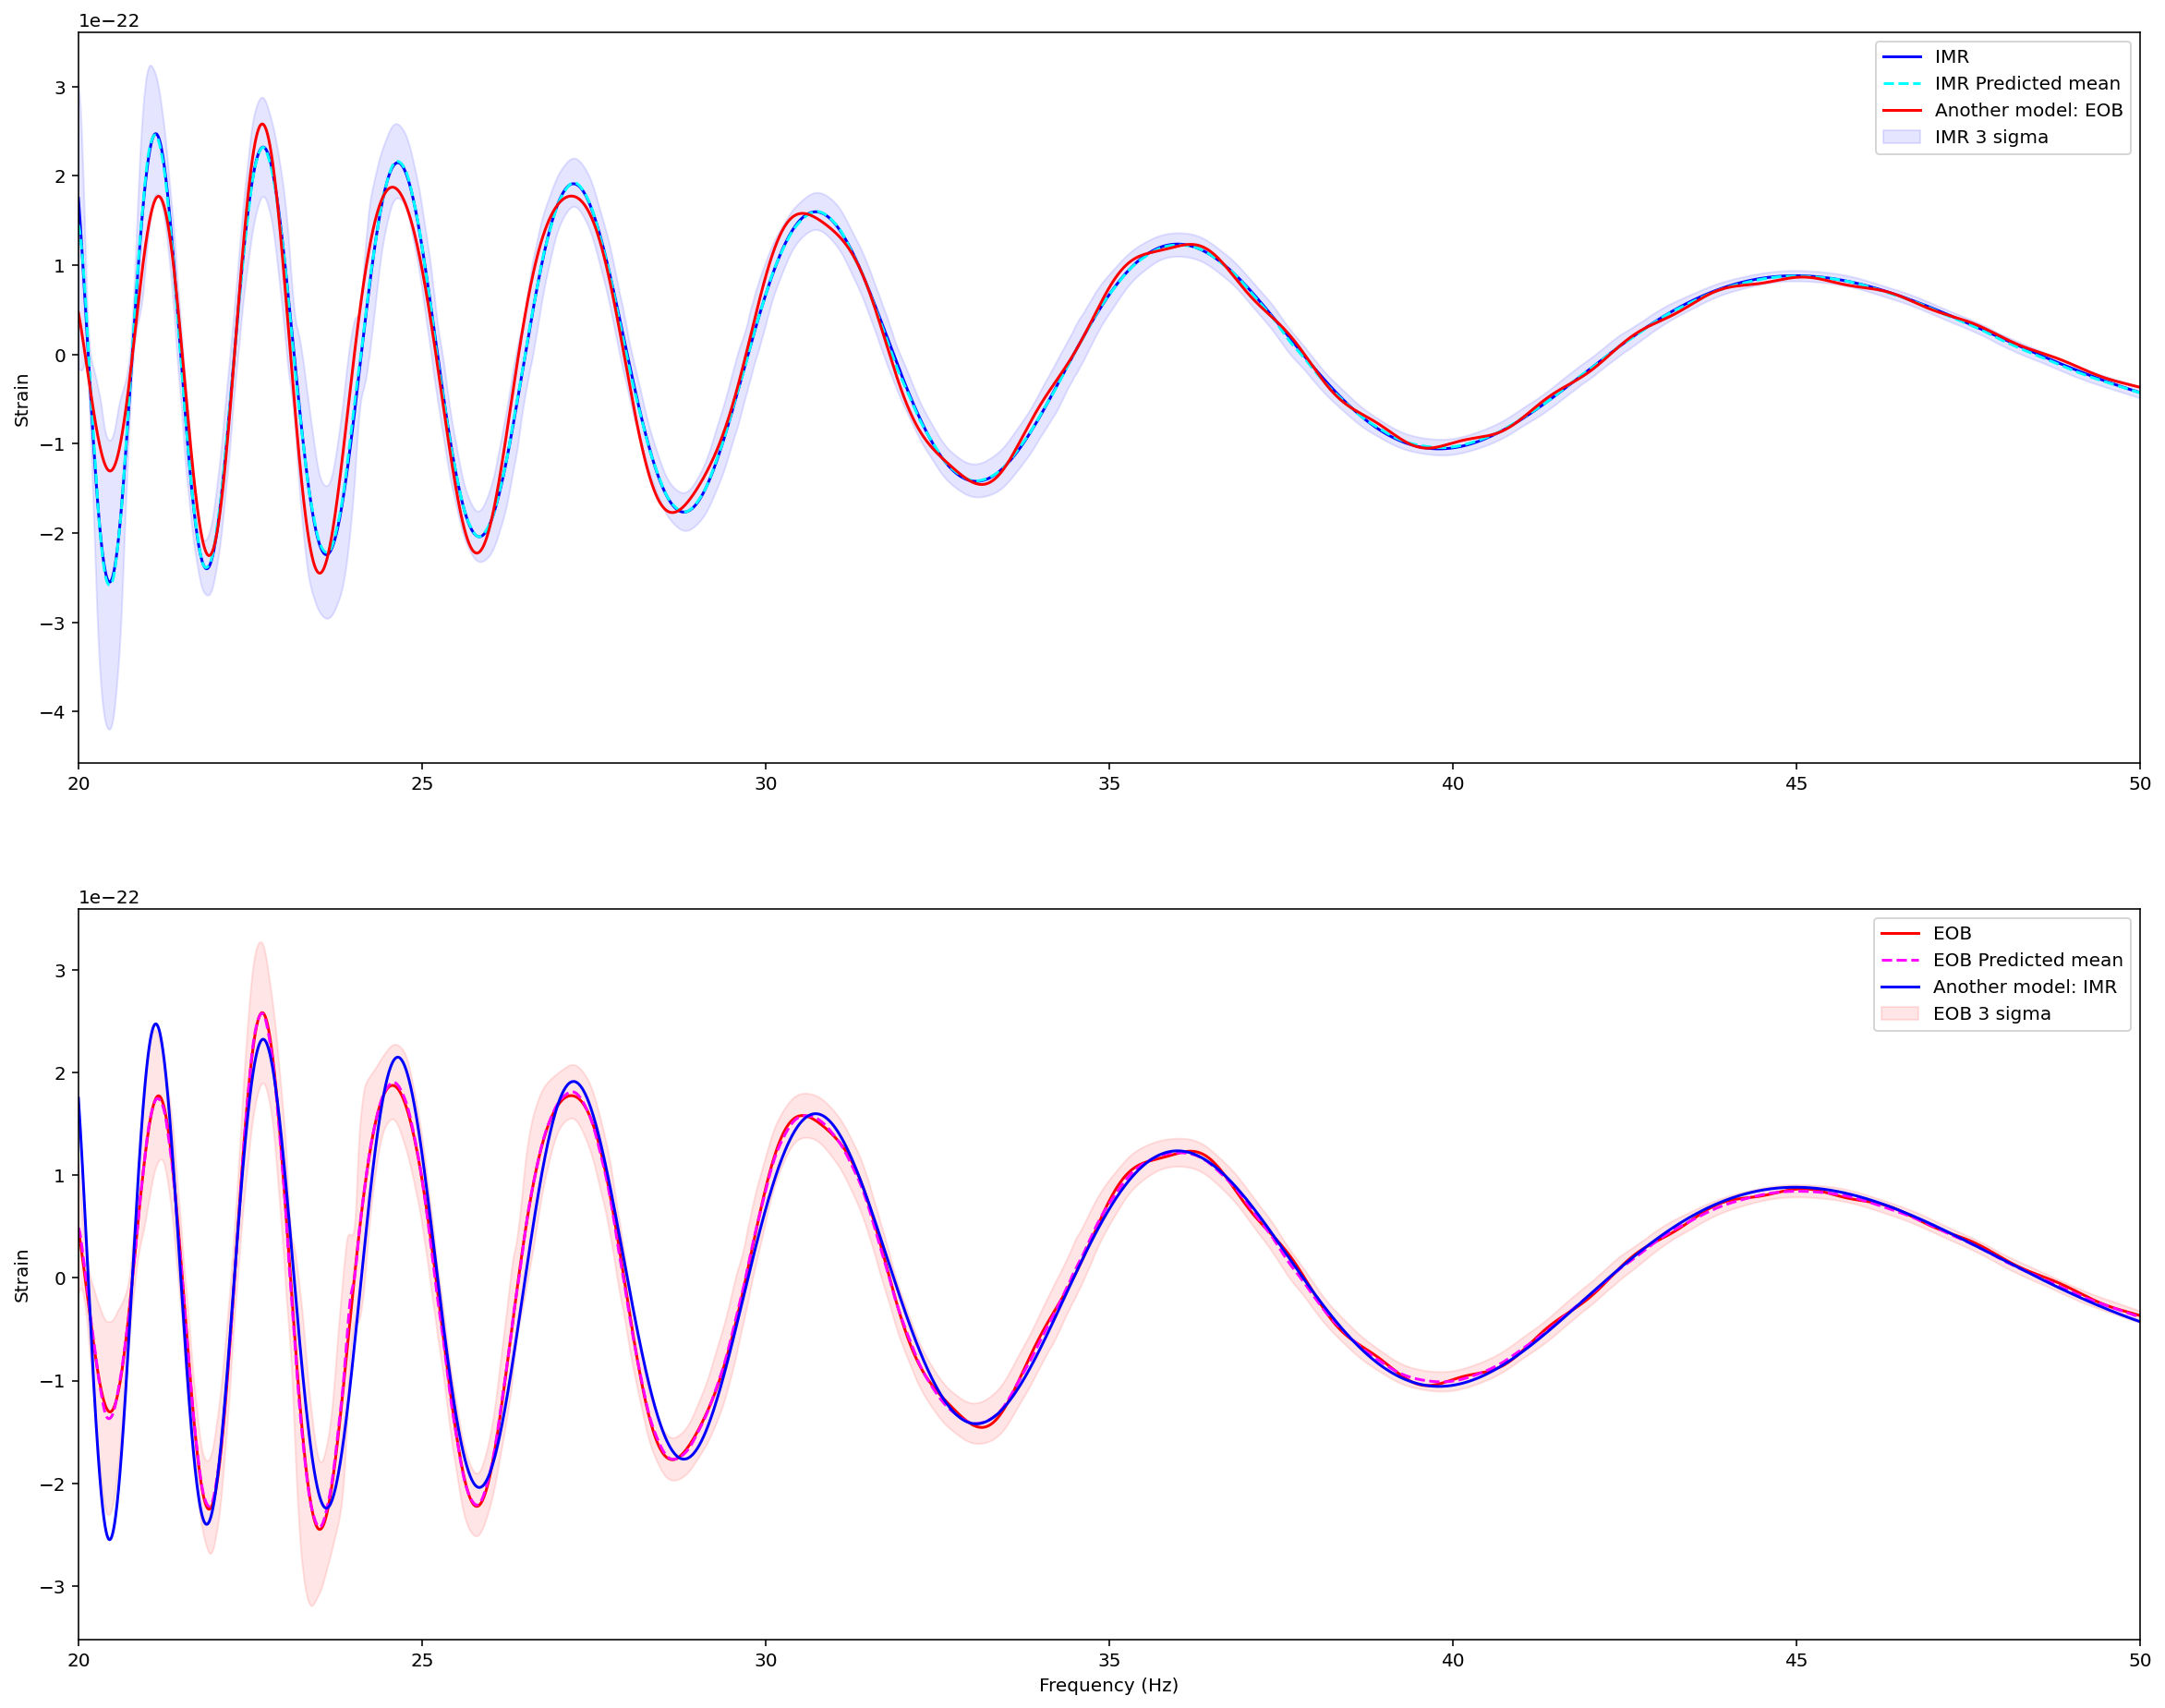

In [60]:
plt.figure(figsize=(20,16))
xlim_low=20
xlim_high=50
nsigma = 3

plt.subplot(2,1,1)
plt.plot(real_freq_test_imr, real_amp_test_imr, label='IMR', color='b')
plt.plot(real_freq_test_imr, real_mean_test_imr, label='IMR Predicted mean', color='cyan',linestyle='--')
plt.fill_between(x=real_freq_test_imr, y1=real_mean_test_imr-nsigma*real_std_test_imr, y2=real_mean_test_imr+nsigma*real_std_test_imr,
                 label=f'IMR {nsigma} sigma', alpha=0.1, color='b')
plt.plot(real_freq_test_eob, real_amp_test_eob, label='Another model: EOB', color='r',linestyle='-')
plt.legend()
plt.xlim(xlim_low,xlim_high)
plt.ylabel('Strain')



plt.subplot(2,1,2)
plt.plot(real_freq_test_eob, real_amp_test_eob, label='EOB', color='r')
plt.plot(real_freq_test_eob, real_mean_test_eob, label='EOB Predicted mean', color='magenta',linestyle='--')
plt.fill_between(x=real_freq_test_eob, y1=real_mean_test_eob-nsigma*real_std_test_eob, y2=real_mean_test_eob+nsigma*real_std_test_eob,
                 label=f'EOB {nsigma} sigma', alpha=0.1, color='r')
plt.plot(real_freq_test_imr, real_amp_test_imr, label='Another model: IMR', color='b',linestyle='-')
plt.legend()
plt.xlim(xlim_low,xlim_high)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Strain')
#plt.savefig('/home/qian.hu/neuron_process_waveform/test/trained_models/gp_reprod.png')
plt.show()

In [9]:
def my_inner_product(hf1,hf2,det,flag):
    inner_prod_complex = bilby.gw.utils.noise_weighted_inner_product(
                            aa=hf1[det.strain_data.frequency_mask],
                            bb=hf2[det.strain_data.frequency_mask],
                            power_spectral_density=det.power_spectral_density_array[det.strain_data.frequency_mask],
                            duration=det.strain_data.duration)

    #inner_prod_complex = det.inner_product_2(hf1, hf2)
    if flag == "c":
        return inner_prod_complex
    elif flag == "r":
        return np.real(inner_prod_complex)
    else:
        raise("Wrong flag!")


def get_dtdphi_withift_zeropad(h1,h2,det):

    psd = det.power_spectral_density_array
    f_array = det.frequency_array
    
    X_of_f = h1*h2.conjugate()/psd
    add_zero = np.zeros(int(63*len(X_of_f)))
    X_of_f = np.append(X_of_f,add_zero)
    X_of_t = np.fft.ifft(X_of_f)
    
    timelength = 1/(f_array[1]-f_array[0])
    t = np.linspace(-timelength/2,timelength/2,len(X_of_t))
    X_shifted = np.roll(X_of_t,len(X_of_t)//2)

    jmax = np.argmax( abs(X_shifted) )
    deltat = t[jmax]
    phase1 = 2*np.pi*f_array*deltat
    
    freq_mask = det.strain_data.frequency_mask
    inner_product = my_inner_product(h1.conjugate(), h2.conjugate()*np.exp(1j*phase1), det, 'c')
    
    deltaphi = -np.angle(inner_product)
    #phase2 = deltaphi
    
    return deltat,deltaphi


def get_shifted_h2_zeropad(h1,h2,det):
    '''
    Return the h2*exp(-i*phase_shift), i.e. h2* exp -i*(2\pi f \Delta t + \Delta \phi)
    '''
    deltat,deltaphi = get_dtdphi_withift_zeropad(h1,h2,det)
    f_array = det.frequency_array
    exp_phase = np.exp(-1j*(2*np.pi*f_array*deltat + deltaphi) )
    return h2*exp_phase



def mismatch(h1, h2, det):
    h2_shifted = get_shifted_h2_zeropad(h1,h2,det)
    norm = (my_inner_product(h1,h1,det,'r')*my_inner_product(h2_shifted,h2_shifted,det,'r'))**0.5
    inner = my_inner_product(h1,h2_shifted,det,'r')

    return 1-inner/norm

In [28]:
'''
duration=32
f_lower=20
sampling_frequency=8192
'''

duration=4
f_lower=20
sampling_frequency=4096


ifos = bilby.gw.detector.InterferometerList(['L1'])
det = ifos[0]
det.duration = duration
det.sampling_frequency=sampling_frequency
det.frequency_mask = det.frequency_array>=f_lower
mask = det.frequency_mask
freq_array = det.frequency_array[mask]

In [29]:
len(freq_array)

8113

In [12]:
import time

In [13]:
mismatches = []
predtimes = []

for look_index in range(testset.n_samples):
    chirp_mass_look = gw_test_dataset.source_parameters['chirp_mass'][look_index]

    x_test_imr, y_test_imr = gw_test_dataset.get_specific_model(look_index, 'IMRPhenomPv2')

    len_data = len(x_test_imr)
    len_context = int(len_data*1)
    context_index = np.sort( np.random.permutation(len_data)[:len_context] )
    target_index = np.arange(len_data)

    x_test_context_imr = x_test_imr[context_index]
    y_test_context_imr = y_test_imr[context_index]

    x_test_target_imr = x_test_imr[target_index]
    x_yest_target_imr = y_test_imr[target_index]

    x_test_target_imr_unsc, y_test_target_imr_unsc = gw_test_dataset.get_specific_model(look_index, 'IMRPhenomPv2', rescalex=False)
    x_test_target_imr_unsc = x_test_target_imr_unsc.squeeze().numpy()
    y_test_target_imr_unsc = y_test_target_imr_unsc.squeeze().numpy()

    nsample = 1
    time1 = time.time()
    mean_imr, std_imr = gwutils.get_predictions(model_pv2v4p, x_test_context_imr.unsqueeze(0), y_test_context_imr.unsqueeze(0),
                                    x_test_target_imr.unsqueeze(0), nsample)
    time2 = time.time()
    predtimes.append(time2-time1)
    
    real_freq_test_imr, real_amp_test_imr = gwutils.unscale_scaled_fdwaveforms(x_test_target_imr_unsc, [y_test_target_imr_unsc], chirp_mass_look)
    real_freq_test_imr, real_mean_test_imr = gwutils.unscale_scaled_fdwaveforms(x_test_target_imr_unsc, [mean_imr], chirp_mass_look)
    real_freq_test_imr, real_std_test_imr = gwutils.unscale_scaled_fdwaveforms(x_test_target_imr_unsc, [std_imr], chirp_mass_look)


    real_amp_test_imr = real_amp_test_imr[0]
    real_mean_test_imr = real_mean_test_imr[0]
    real_std_test_imr = real_std_test_imr[0]

    interpolator_pred = scipy.interpolate.CubicSpline(real_freq_test_imr, real_mean_test_imr)
    interped_h_pred = interpolator_pred(det.frequency_array)

    interpolator_truth = scipy.interpolate.CubicSpline(real_freq_test_imr, real_amp_test_imr)
    interped_h_truth = interpolator_truth(det.frequency_array)

    mismatches.append(mismatch(interped_h_truth, interped_h_pred, det))

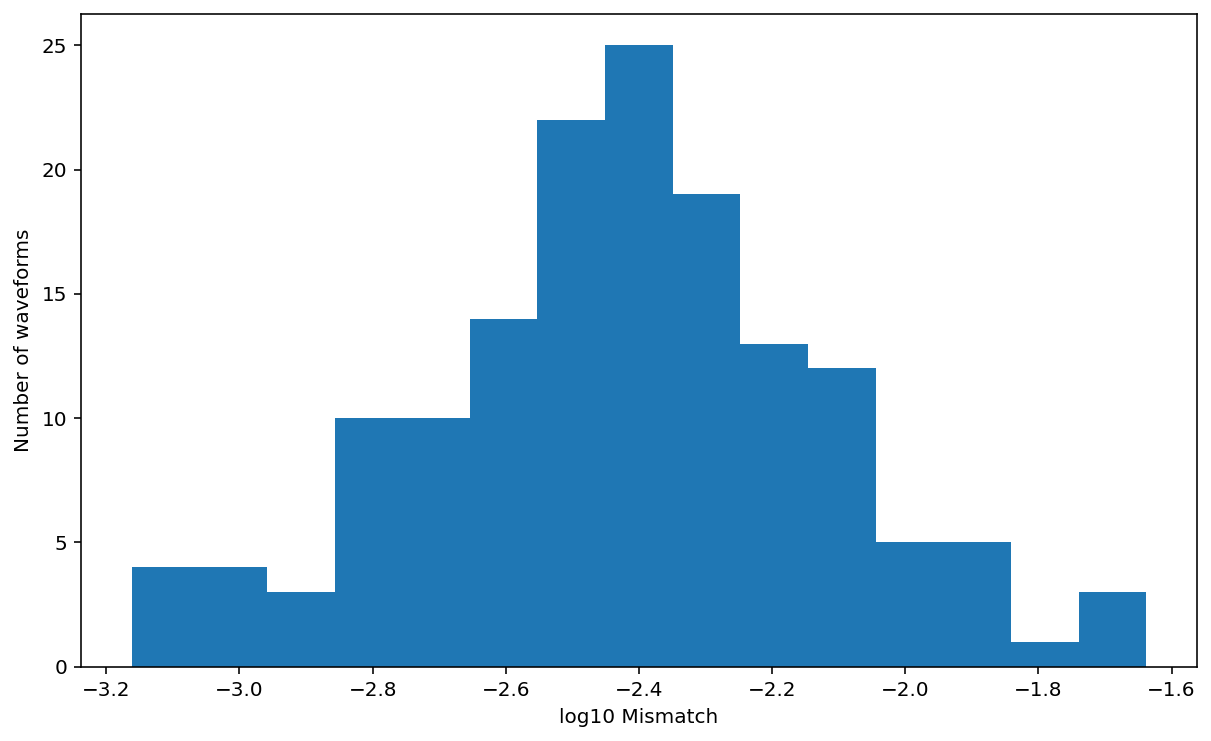

In [19]:
plt.figure(figsize=(10,6))

x,xx,xxx = plt.hist(np.log10(mismatches), bins=15)

plt.xlabel('log10 Mismatch')
plt.ylabel('Number of waveforms')
#plt.xscale('log')
plt.show()

In [15]:
np.median(mismatches), min(mismatches), max(mismatches)

(0.0037764256595854695, 0.0006886372796817142, 0.023003281169811762)

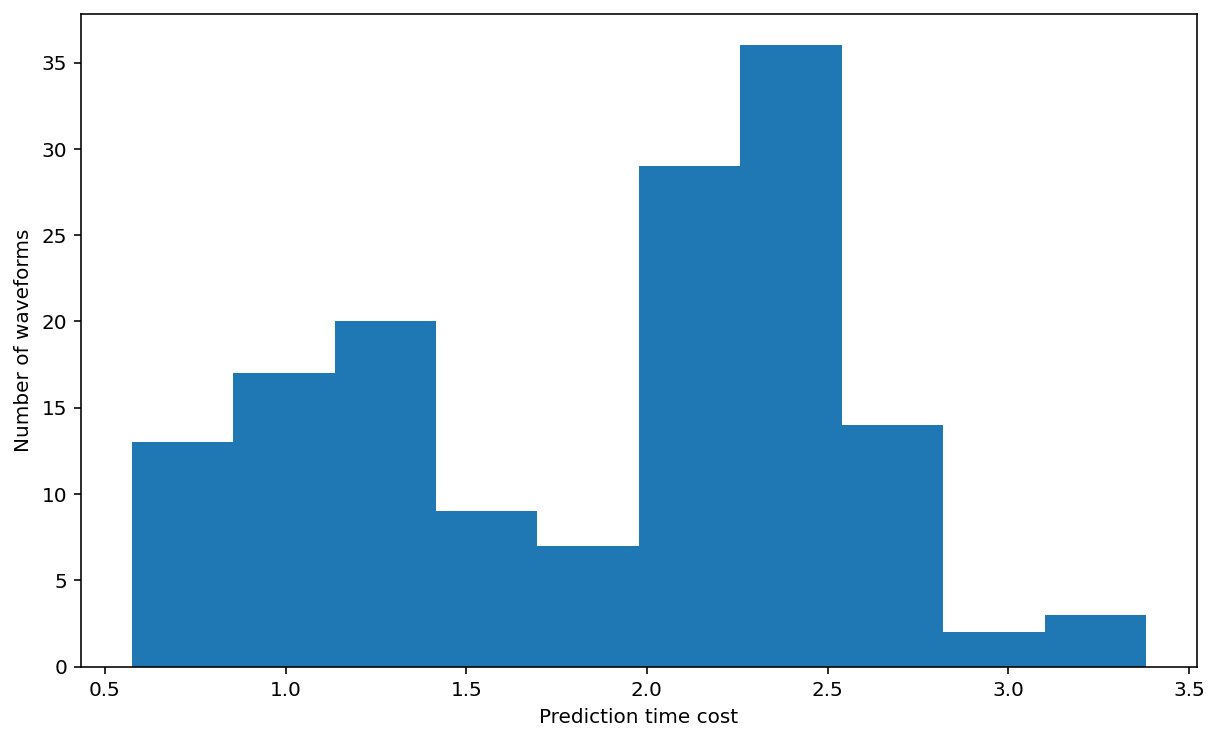

In [16]:
plt.figure(figsize=(10,6))

x,xx,xxx = plt.hist(predtimes)

plt.xlabel('Prediction time cost')
plt.ylabel('Number of waveforms')
plt.show()